In [1]:
import os
import numpy as np
import pandas as pd
pd.set_option('display.expand_frame_repr', False)
import gspread
import matplotlib.pyplot as plt

In [2]:
exps = ['0930_jiuhai_seed-0123']

datasets = ['ogb-molpcba', 'ogb-molhiv', 'ogbg-ppa', 'UPFD', 'SBM-Isolation', 'SBM-Environment', 'RotatedMNIST', 'ColoredMNIST']
algorithms = ['ERM', 'groupDRO', 'IRM', 'deepCORAL', 'DANN', 'DANN-G', 'MLDG', 'FLAG']
models = ['gin', 'mlp', 'gin_10_layers', 'gcn', 'gin_virtual', 'transformer', 'cheb', '3wlgnn']


base_model = {
    'ogb-molpcba': 'gin_virtual', 
    'ogb-molhiv': 'gin_virtual',
    'ogbg-ppa': 'gin_virtual',
    'UPFD': 'cheb',
    'SBM-Isolation': 'cheb',
    'SBM-Environment': 'gin_10_layers',
    'RotatedMNIST': 'cheb',
    'ColoredMNIST': 'cheb',
}


def parse_performance(d, a, m, exps, assert_length=True):
    performances = []
    for exp in exps:
        seeds = [0, 1, 2]
        for seed in seeds:
            test_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_test_eval.csv', sep=',')
            test_eval = test_eval.dropna(axis=0)
            test_eval = test_eval.iloc[:,1].to_numpy()
            val_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_val_eval.csv', sep=',')
            val_eval = val_eval.dropna(axis=0)
            val_eval = val_eval.iloc[:,1].to_numpy()
            train_eval = pd.read_csv(f'./logs/{exp}/{d}_{a}_{m}_seed-{seed}_train_eval.csv', sep=',')
            train_eval = train_eval.dropna(axis=0)
            train_eval = train_eval.iloc[:,1].to_numpy()
            nepoch = max([len(train_eval), len(val_eval), len(test_eval)])
            performances.append((train_eval[:nepoch], val_eval[:nepoch], test_eval[:nepoch]))
    return performances
    
def filter_test_performance(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(test_eval[np.argmax(val_eval)])
    return results


def filter_performance_gaps(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append((train_eval[np.argmax(val_eval)]-test_eval[np.argmax(val_eval)]))
    return results

def filter_num_epoches(performances):
    results = []
    for per in performances:
        train_eval, val_eval, test_eval = per
        results.append(len(train_eval))
    return results

def filter_uncertainty(results):
    results = np.array(results)
    if len(results) == 1:
        return f'{results[0]:.3f}±?'
    return f'{np.mean(results):.3f}±{np.std(results):.3f}'


def filter_plot(performances):
    results = []
    plt.figure(figsize=(10, 5))
    for per in performances:
        train_eval, val_eval, test_eval = per
        plt.plot(train_eval, 'r')
        plt.plot(val_eval, 'g')
        plt.plot(test_eval, 'b')
    plt.show()
    return results


def parse(mode, **kwargs):
    try:
        if mode == 'test_performance':
            return filter_uncertainty(filter_test_performance(parse_performance(**kwargs)))
        if mode == 'performance_gap':
            return filter_uncertainty(filter_performance_gaps(parse_performance(**kwargs)))
        if mode == 'num_epoches':
            return filter_uncertainty(filter_num_epoches(parse_performance(**kwargs)))
        if mode == 'convergence_plot':
            return filter_plot(parse_performance(**kwargs))
        else:
            raise NotImplementError
    except OSError as e:
        return 'fnf'
    except pd.errors.EmptyDataError as e:
        return 'err'

In [3]:
table = []
m = models[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, a in enumerate(algorithms):
        table_dataset.append(parse('test_performance', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=algorithms)

print(table)
#print(table.to_csv(index=False, header=False))

                         ERM     groupDRO          IRM    deepCORAL DANN DANN-G MLDG         FLAG
ogb-molpcba      0.247±0.002  0.208±0.003  0.128±0.003  0.155±0.006  fnf    fnf  fnf          err
ogb-molhiv       0.744±0.012  0.730±0.008  0.697±0.034  0.700±0.043  fnf    fnf  fnf  0.760±0.014
ogbg-ppa                 err  0.646±0.017  0.610±0.016  0.714±0.008  fnf    fnf  fnf  0.699±0.018
UPFD             0.628±0.006  0.631±0.007  0.629±0.002  0.634±0.012  fnf    fnf  fnf  0.630±0.006
SBM-Isolation            fnf          fnf          fnf          fnf  fnf    fnf  fnf          fnf
SBM-Environment  0.767±0.003  0.761±0.002  0.763±0.002  0.766±0.004  fnf    fnf  fnf  0.770±0.010
RotatedMNIST             fnf          fnf          fnf          fnf  fnf    fnf  fnf          fnf
ColoredMNIST             fnf          fnf          fnf          fnf  fnf    fnf  fnf          fnf


In [4]:
table = []
a = algorithms[0]
for i, d in enumerate(datasets):
    table_dataset = []
    for j, m in enumerate(models):
        table_dataset.append(parse('num_epoches', d=d, a=a, m=m, exps=exps))
    table.append(table_dataset)
    
table = pd.DataFrame(table, index=datasets, columns=models)

print(table)
#print(table.to_csv(index=False, header=False))

                            gin  mlp gin_10_layers             gcn     gin_virtual transformer cheb 3wlgnn
ogb-molpcba      247.000±32.690  fnf           fnf  176.333±18.409   191.000±7.483         fnf  fnf    fnf
ogb-molhiv         64.667±9.877  fnf           fnf    55.667±2.357   92.000±25.573         fnf  fnf    fnf
ogbg-ppa                    err  fnf           fnf   93.333±27.717   74.667±20.270         fnf  fnf    fnf
UPFD             101.000±15.769  fnf           fnf   88.000±15.769    45.000±5.657         fnf  fnf    fnf
SBM-Isolation               fnf  fnf           fnf             fnf             fnf         fnf  fnf    fnf
SBM-Environment   158.333±4.922  fnf           fnf    91.333±8.731  223.000±17.795         fnf  fnf    fnf
RotatedMNIST                fnf  fnf           fnf             fnf             fnf         fnf  fnf    fnf
ColoredMNIST                fnf  fnf           fnf             fnf             fnf         fnf  fnf    fnf


ogb-molpcba


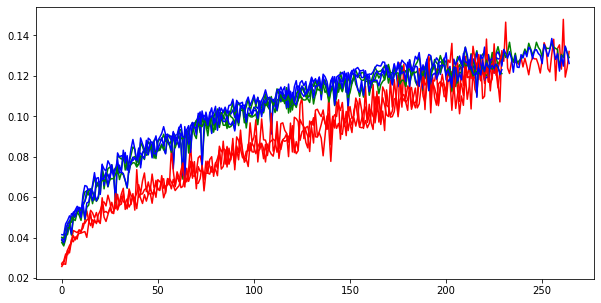

ogb-molhiv


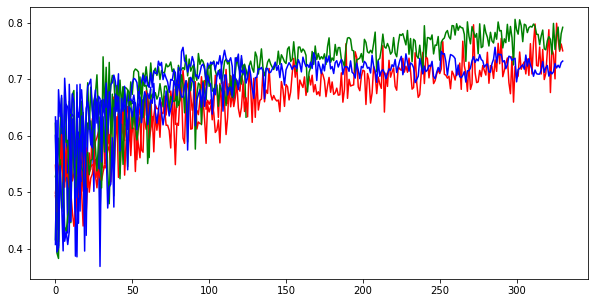

ogbg-ppa


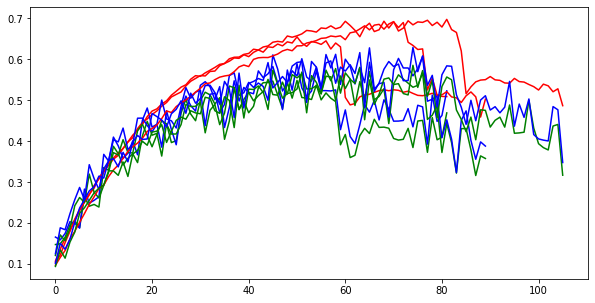

UPFD


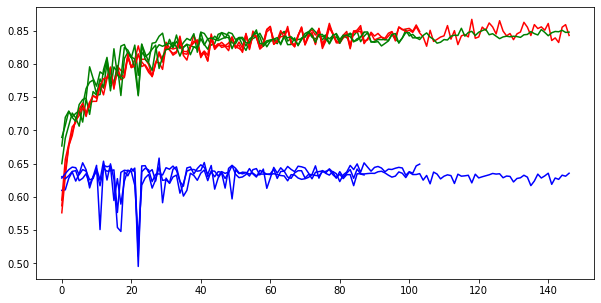

SBM-Isolation
SBM-Environment


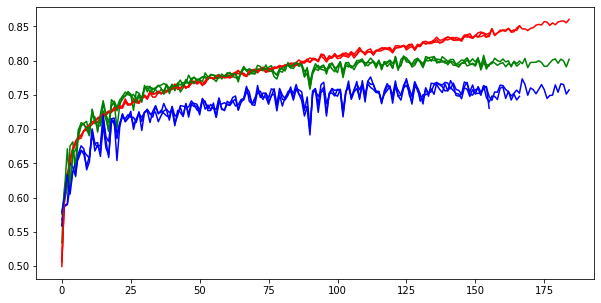

RotatedMNIST
ColoredMNIST


In [8]:
for d in datasets:
    print(d)
    parse('convergence_plot', d=d, a='IRM', m='gin', exps=exps)